<a href="https://colab.research.google.com/github/hansbrunner/safety_data/blob/main/Clozapine/Clozapine_adverse_events_temporal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
In this analysis, I explored various data analysis techniques in the field of drug safety surveillance,
with a particular focus on adverse event (AE) reporting trends over time, categorized by System Organ Class (SOC).
These methods provide valuable insights into how the frequency of adverse event reporting changes throughout the treatment period,
potentially highlighting emerging safety signals or shifts in patient risk. Such analyses are crucial for understanding the safety profiles
of medications across a range of therapeutic areas, including psychiatry and neurology.

The analysis centers on detecting significant change points in the reporting of adverse events for different SOC categories.
By examining these trends over time, we can identify periods where specific adverse events—such as hematological or cardiovascular
complications—increase or decrease in frequency, which may reflect underlying changes in drug use, patient management, or broader external factors.

Key Focus Areas:
AE Reporting Trends: Investigating how the reporting of adverse events changes over specific time intervals (e.g., quarterly).
Change Point Detection: Applying change point detection techniques to identify key moments when the rate of AE reporting shifts,
potentially signaling critical risk periods, new safety concerns or changed usage.
"""

In [1]:
# Load PT-to-SOC mapping file generated in "Convert_AE_PT_to_SOC_Clozapine"
import pandas as pd

# Load mappings
map_df = pd.read_csv("pt_soc_mapping.csv",index_col=0) # "pt_soc_mapping.csv" must be uploaded

# Rename nan SOCs to 'Undefined'
map_df['SOC_normalized'].fillna('Undefined', inplace=True)
# Rename and remove columns
map_df.drop(columns=['SOC'], inplace=True)
map_df.rename(columns={'SOC_normalized': 'SOC'}, inplace=True)


In [46]:
# get data from fda
import time
import requests
import json
base_url = 'https://api.fda.gov/drug/event.json'
# Parameters for the API request
limit = 1000  # Fetch 1000 reports at a time
total_reports_to_fetch = 25000  # The total number of reports to getch - Maximum
total_reports_fetched = 0  # Counter
data = []  # To store all fetched reports

# Loop to combine and fetch the data in chunks of 1000
while total_reports_fetched < total_reports_to_fetch:
    # Fetch the next batch of reports
    url = f'{base_url}?search=clozapine&limit={limit}&skip={total_reports_fetched}'
    response = requests.get(url)
    _data = response.json()

    # Add the fetched results to the all_data list
    data.extend(_data['results'])

    # Update the total number of reports fetched
    total_reports_fetched += len(_data['results'])

    # Sleep
    time.sleep(1)

In [5]:
# Function to extract information from FDA json to pandas DataFrame
import numpy as np
def extract_fda_data(json_data):
    #List to hold all the extracted data
    extracted_data = []

    # Loop through all report in the dataset
    for i, report in enumerate(json_data):
        # Assign patient number
        patient_number = i + 1  # A simple count for each patient

        # Extract fixed fields from report
        drug_name = report['patient']['drug'][0].get('medicinalproduct',"Unknown") # get product
        indication_for_use = report['patient']['drug'][0].get("drugindication","PRODUCT USED FOR UNKNOWN INDICATION")  # Indication
        age = report.get('patient', {}).get('patientonsetage', 'Unknown')  # Patient's age
        age_unit = report.get('patient', {}).get('patientonsetageunit', '')  # Age unit (e.g., years, months)
        # If unit in months, convert to years
        if age and age_unit == '802':
            age = np.floor(int(age)/12).astype(int)
        gender = report.get('patient', {}).get('patientsex', 'Unknown')  # Gender: 1 = Male, 2 = Female
        gender = 'Male' if gender == '1' else 'Female' if gender == '2' else 'Unknown'
        report_date = report.get('receiptdate', 'Unknown')  # Date of report

        # Extract AE specific data
        adverse_events = report.get('patient', {}).get('reaction', [])
        for event in adverse_events:
            ae_pt = event.get('reactionmeddrapt', 'Unknown')  # AE with Preferred Term (PT)
            outcome = event.get('reactionoutcome', 'Unknown')  # Outcome

            # Report type
            report_type = report.get('primarysource', {}).get('qualification', 'Unknown')
            report_type = {
                '1': 'Healthcare Professional',
                '2': 'Consumer',
                '3': 'Other'
            }.get(report_type, 'Other')

            # Store the extracted data for the AE event
            extracted_data.append({
                'Patient #': patient_number,
                'AE PT': ae_pt,
                'Outcome': outcome,
                'Age': age,
                'Gender': gender,
                'Report Date': report_date,
                'Drug Name': drug_name,
                'Indication for Use': indication_for_use,
                'Report Type': report_type,
            })

    # Convert the list of extracted data into a Pandas DataFrame
    df = pd.DataFrame(extracted_data)

    return df

In [47]:
# Convert json to pandas df
df = extract_fda_data(data)
print(df.head())

# Append SOCs based on PT
map_df.rename(columns={'PT': 'AE PT'}, inplace=True)
df = pd.merge(df, map_df, on='AE PT', how='left')

# Convert report date to datetime
df['Report Date'] = pd.to_datetime(df['Report Date'], errors='coerce')

print(df.head())

   Patient #                             AE PT Outcome Age Gender Report Date  \
0          1        Neutrophil count increased       6  46   Male    20150819   
1          1  White blood cell count increased       3  46   Male    20150819   
2          1                Abnormal behaviour       6  46   Male    20150819   
3          2              Atrial septal defect       1  19   Male    20140522   
4          2         Bundle branch block right       1  19   Male    20140522   

  Drug Name Indication for Use              Report Type  
0  CLOZARIL      SCHIZOPHRENIA  Healthcare Professional  
1  CLOZARIL      SCHIZOPHRENIA  Healthcare Professional  
2  CLOZARIL      SCHIZOPHRENIA  Healthcare Professional  
3  CLOZARIL      SCHIZOPHRENIA  Healthcare Professional  
4  CLOZARIL      SCHIZOPHRENIA  Healthcare Professional  
   Patient #                             AE PT Outcome Age Gender Report Date  \
0          1        Neutrophil count increased       6  46   Male  2015-08-19   
1  

In [48]:
# find top 5 AE SOCs
soc_counts = df['SOC'].value_counts()

# Get the top 5 SOCs by frequency
top_5 = soc_counts.head(5).index.tolist()

df_top_soc = df[df['SOC'].isin(top_5)]

print(top_5)

['Blood and lymphatic system disorders', 'Psychiatric disorders', 'Nervous system disorders', 'General disorders and administration site conditions', 'Injury, poisoning and procedural complications']


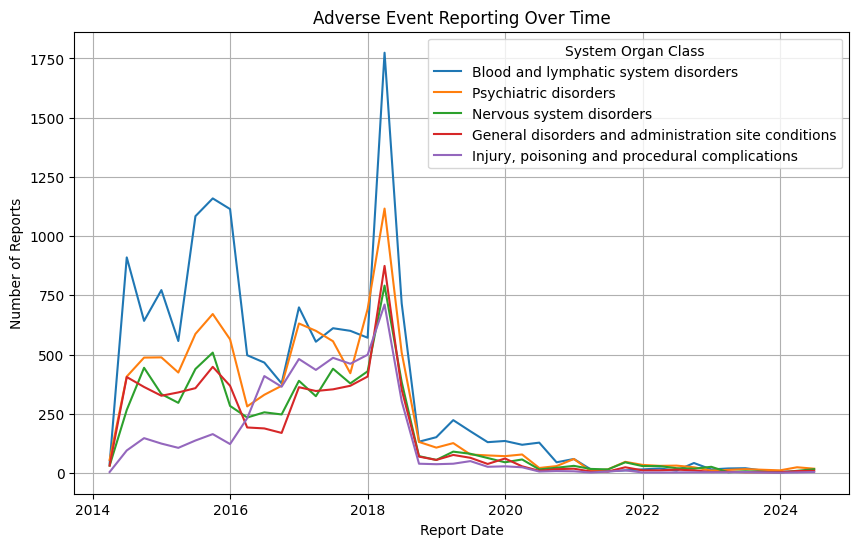

In [49]:
import matplotlib.pyplot as plt

# plot reporting per month
df_grouped = df_top_soc.groupby([pd.Grouper(key='Report Date', freq='Q'), 'SOC']).size().reset_index(name='Count') # Q for quaterly

# Plot the reporting trends over time
plt.figure(figsize=(10, 6))

for soc in top_5:
    # Get specific AE
    soc_data = df_grouped[df_grouped['SOC'] == soc]

    # Plot the number of reported AE over time
    plt.plot(soc_data['Report Date'], soc_data['Count'], label=soc)

# Add all reports - show similar trends
#all_reports = df.groupby(pd.Grouper(key='Report Date', freq='Q')).size().reset_index(name='Count') # Q for quaterly
#plt.plot(all_reports['Report Date'], all_reports['Count'], label='All Reports')

# Add labels and title
plt.title('Adverse Event Reporting Over Time')
plt.xlabel('Report Date')
plt.ylabel('Number of Reports')
plt.legend(title="System Organ Class")
plt.grid(True)

# Show the plot
plt.show()

10   2016-09-30
15   2017-12-31
20   2019-03-31
Name: Report Date, dtype: datetime64[ns]


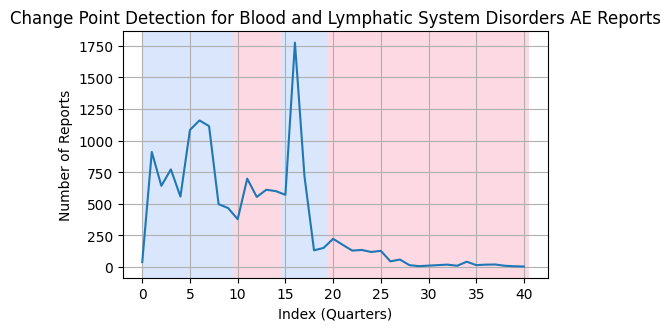

In [50]:
import ruptures as rpt

# Point change analysis of 'Blood and lymphatic system disorders'
blood_df = df[df['SOC'] == 'Blood and lymphatic system disorders']

# Quaterly reports
blood_df_grouped = blood_df.groupby(pd.Grouper(key='Report Date', freq='Q')).size().reset_index(name='Count')
counts = blood_df_grouped['Count'].values

# PELT for point change detection
algo = rpt.Pelt(model="rbf").fit(counts)
change_points = algo.predict(pen=.75)
#print(change_points)

# Plot
rpt.display(counts, change_points, figsize=(5, 3))

# Tidy
plt.title('Change Point Detection for Blood and Lymphatic System Disorders AE Reports')
plt.xlabel('Index (Quarters)')
plt.ylabel('Number of Reports')
plt.grid(True)

# Print the dates for change points
change_point_dates = blood_df_grouped['Report Date'].iloc[change_points[:-1]]
print(change_point_dates)

In [ ]:
"""
The patterns of adverse event (AE) reporting for Clozapine have clearly shifted over time, which is evident in the
"Blood and lymphatic system disorder" reports. However, these changes in reporting are not specific to this particular
type of AE, indicating that broader factors related to the usage, monitoring, and/or regulatory requirements for
Clozapine may have contributed to these trends.

The change points observed in the analysis likely correspond to significant milestones in the development and
implementation of the Clozapine Risk Evaluation and Mitigation Strategy (REMS). REMS played a critical role in increasing
the frequency and stringency of monitoring, especially for hematological conditions like neutropenia.

A notable decline in AE reporting around 2019 may be attributed to a decrease in Clozapine usage.
This decline could also be linked to extended blood monitoring intervals, as well as the logistical
challenges posed by the COVID-19 pandemic, which may have reduced overall AE detection and reporting.
However, concrete data on Clozapine prescription trends are difficult to access.
"""